In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from math import sqrt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as cols
from matplotlib.collections import LineCollection
import pyarrow.feather as feather
from scipy.stats import iqr

In [2]:
# OPTIONS

train_sds = [0.05, 0.1, 'meta']
test_sds = np.around(np.linspace(0.02,0.3,15), decimals=2)
colors = ['#9658EF', '#C16FAC', '#FF914D']
labels = ['Low volatility', 'Medium volatility', 'Meta-volatility']
ylabels = [r'% Optimal',r'% Switch']
my_x_label = 'Volatility'



In [3]:
# Read pickle files
raw_df_0_05 = pd.read_pickle("../data/rnn_raw_data/merged_rnn_data_train_sd_0_05")
raw_df_0_1 = pd.read_pickle("../data/rnn_raw_data/merged_rnn_data_train_sd_0_1")
raw_df_met = pd.read_pickle("../data/rnn_raw_data/merged_rnn_data_train_sd_met")


# df_0_05 = df_0_05.groupby(['rnn_id', 'run', 'test_sd'], as_index=False).mean({'accuracy', 'is_switch'})
# df_0_1 = df_0_1.groupby(['rnn_id', 'run', 'test_sd'], as_index=False).mean({'accuracy', 'is_switch'})
# df_met = df_met.groupby(['rnn_id', 'run', 'test_sd'], as_index=False).mean({'accuracy', 'is_switch'})

# Add train_sd column
raw_df_0_05['train_sd'] = 0.05
raw_df_0_1['train_sd'] = 0.1
raw_df_met['train_sd'] = 'meta'

In [4]:
# Get data points for boxplot
df_0_05 = raw_df_0_05.groupby(['rnn_id', 'run', 'test_sd'], as_index = False).mean({'accuracy', 'is_switch'})
df_0_1 = raw_df_0_1.groupby(['rnn_id', 'run', 'test_sd'], as_index = False).mean({'accuracy', 'is_switch'})
df_met = raw_df_met.groupby(['rnn_id', 'run', 'test_sd'], as_index = False).mean({'accuracy', 'is_switch'})
df_0_05 = df_0_05.groupby(['test_sd','rnn_id'], as_index=False).median({'accuracy', 'is_switch'})
df_0_1 = df_0_1.groupby(['test_sd','rnn_id'], as_index=False).median({'accuracy', 'is_switch'})
df_met = df_met.groupby(['test_sd','rnn_id'], as_index=False).median({'accuracy', 'is_switch'})

In [5]:
# Round test_sd values
df_0_05 = df_0_05.round({'test_sd' : 2})
df_0_1 = df_0_1.round({'test_sd' : 2})
df_met = df_met.round({'test_sd' : 2})

In [6]:
# Exponential decay function
def exp_fit(x, y0, a, k):
    y = (y0-a) * np.exp(-k * x) + a
    return y

In [7]:
def plot_confidence_interval(x, values, color, ax, z=1.96, horizontal_line_width=0.005):
    mean = np.nanmean(values)
    stdev = np.nanstd(values)
    confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    ax.plot([x, x], [top, bottom], color=color, alpha=1, lw=0.5)
    ax.plot([left, right], [top, top], color=color, alpha=1, lw=0.5)
    ax.plot([left, right], [bottom, bottom], color=color, alpha=1, lw=0.5)
    ax.plot(x, mean, 'o', color=color, alpha =1, markersize = 3)
        
    return mean, confidence_interval

In [8]:
# Curve fit
x = np.around(np.linspace(0.02,0.3,15), decimals=2)
df_list = [df_0_05, df_0_1, df_met]
param_bounds=([0,0,0],[1,1,np.inf])
y_acc = []
y_switch = []
for i, df in enumerate(df_list):
    fit_acc = curve_fit(exp_fit, np.array(df['test_sd']), np.array(df['accuracy']),
                        maxfev = 6000, bounds = param_bounds)
    
    y_acc.append(exp_fit(x, y0= fit_acc[0][0], a = fit_acc[0][1], k = fit_acc[0][2]))
    
    fit_switch = curve_fit(exp_fit, np.array(df['test_sd']), np.array(df['is_switch']), maxfev = 6000)
    
    y_switch.append(exp_fit(x, y0= fit_switch[0][0], a = fit_switch[0][1], k = fit_switch[0][2]))

    #y_switch.append(fit_switch[0][0] * np.exp(-fit_switch[0][1] * x) + fit_switch[0][2])
    
    
    print('START')
    print('Train SD: {}'.format(train_sds[i]))
    print('Accuracy')
    print('intercept y0 = {}'.format(fit_acc[0][0]))
    print('asymptote a = {}'.format(fit_acc[0][1]))
    print('decay rate k = {}'.format(fit_acc[0][2]))
    print('Switch')
    print('intercept y0 = {}'.format(fit_switch[0][0]))
    print('asymptote a = {}'.format(fit_switch[0][1]))
    print('decay rate k = {}'.format(fit_switch[0][2]))
    print('END')
    
    

START
Train SD: 0.05
Accuracy
intercept y0 = 0.7644687892269848
asymptote a = 0.262640359104069
decay rate k = 9.329371683096852
Switch
intercept y0 = 0.02821018046066762
asymptote a = 0.2942398593692986
decay rate k = 4.0317892788386445
END
START
Train SD: 0.1
Accuracy
intercept y0 = 0.7827311184723992
asymptote a = 0.27013222914205715
decay rate k = 7.238354122857522
Switch
intercept y0 = 0.05813386310525646
asymptote a = 0.384511343148026
decay rate k = 2.87806268897971
END
START
Train SD: meta
Accuracy
intercept y0 = 0.759983191775142
asymptote a = 0.2736300910786768
decay rate k = 7.20594616383727
Switch
intercept y0 = 0.04746335351931174
asymptote a = 0.40753228441340883
decay rate k = 3.3212360327359263
END


In [9]:
# mean bayesian predictions
x = np.arange(0,15)
y_acc[0] = exp_fit(x, y0=0.68, a=0.26, k=0.19)
y_acc[1] = exp_fit(x, y0=0.71, a=0.27, k=0.14)
y_acc[2] = exp_fit(x, y0=0.69, a=0.27, k=0.14)

In [10]:
y_switch[0] = exp_fit(x, y0=0.05, a=0.30, k=0.07)
y_switch[1] = exp_fit(x, y0=0.08, a=0.40, k=0.05)
y_switch[2] = exp_fit(x, y0=0.07, a=0.42 , k=0.06)

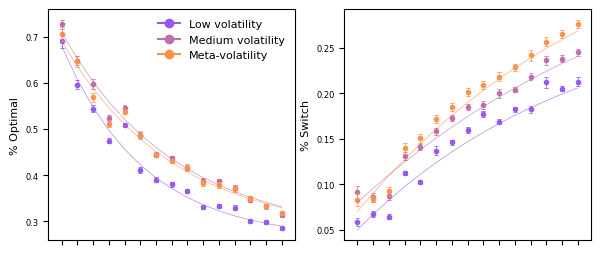

In [11]:
# figure size
fig, axs = plt.subplots(1,2, figsize=(7,3))

x = np.around(np.linspace(0.02,0.3,15), decimals=2)

my_labels =  ['.02', '.04', '.06', '.08', '.1', '.12', '.14', '.16', '.18', '.2', '.22', '.24', '.26', '.28', '.3']

custom_lines = [Line2D([0], [0], marker='o', color=colors[0], label=labels[0]),
                Line2D([0], [0], marker='o', color=colors[1], label=labels[1]),
                Line2D([0], [0], marker='o', color=colors[2], label=labels[2])]

for ax in range(2):
    for test_sd in test_sds:
        for i, train_sd in enumerate(train_sds):
            df = df_list[i]
            df_filt = df[(df['test_sd']==test_sd)]
            my_values = [df_filt.accuracy.to_numpy(), df_filt.is_switch.to_numpy()]
            my_ys = [y_acc, y_switch]
            
            plot_confidence_interval(x=test_sd, 
                         values=my_values[ax],
                         color=colors[i],
                         ax=axs[ax],)
                
            axs[ax].plot(x, my_ys[ax][i], color=colors[i], lw=0.25, alpha = 0.1)
            axs[ax].tick_params(labelsize=6)

    axs[ax].legend(handles=custom_lines, frameon=False, prop={'size': 8})
    axs[ax].set_xticks(np.around(np.linspace(0.02,0.3,15), decimals=2), labels = my_labels)
    axs[ax].set_ylabel(ylabels[ax], fontsize=8)

#axs[1].set_xlabel(my_x_label, fontsize=7)
axs[1].get_legend().remove()

plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)


#plt.show()
plt.savefig('../plots/accuracy_switch_plot.svg', dpi = 300, bbox_inches='tight')

In [12]:
# save median values for stan
df_0_05.groupby(['test_sd']).mean()[['accuracy', 'is_switch']].to_csv('../data/rnn_raw_data/train_sd_0_05.csv')
df_0_1.groupby(['test_sd']).mean()[['accuracy', 'is_switch']].to_csv('../data/rnn_raw_data/train_sd_0_1.csv')
df_met.groupby(['test_sd']).mean()[['accuracy', 'is_switch']].to_csv('../data/rnn_raw_data/train_sd_met.csv')

In [13]:
acc = []
switch = []
test_sd = []
grp = []
id = []
n = len(df_0_05['accuracy'])

In [14]:
acc.append(df_0_05['accuracy'])
acc.append(df_0_1['accuracy'])
acc.append(df_met['accuracy'])

switch.append(df_0_05['is_switch'])
switch.append(df_0_1['is_switch'])
switch.append(df_met['is_switch'])

test_sd.append(df_0_05['test_sd'])
test_sd.append(df_0_1['test_sd'])
test_sd.append(df_met['test_sd'])

id.append(df_0_05['rnn_id'])
id.append(df_0_1['rnn_id'])
id.append(df_met['rnn_id'])


grp.append(['Low']*n)
grp.append(['Medium']*n)
grp.append(['Meta']*n)

In [15]:
df = pd.DataFrame({'acc':np.array(acc).flatten(), 'switch':np.array(switch).flatten(), 'test_sd':np.array(test_sd).flatten(),'grp':np.array(grp).flatten(),
                  'id': np.array(id).flatten()})
df.to_csv('../data/intermediate_data/accuracy_switch_all_levels_data.csv')

In [16]:
# long format
df1 = df.pivot(index = ['grp', 'id'], columns = 'test_sd', values = ['acc']).reset_index()
df1.to_csv('../data/intermediate_data/accuracy_all_levels_wide.csv')

In [17]:
df1 = df.pivot(index = ['grp', 'id'], columns = 'test_sd', values = ['switch']).reset_index()
df1.to_csv('../data/intermediate_data/switch_all_levels_wide.csv')

# Barplots

In [18]:
df_list = [df_0_05, df_0_1, df_met]
DV = ['accuracy', 'is_switch']
x = ['Low', 'Medium', 'Meta']

In [19]:
def get_mean_confidence_interval(values, z=1.96):
    mean = np.nanmean(values)
    stdev = np.nanstd(values)
    confidence_interval = z * stdev / sqrt(len(values))
    
    return mean, confidence_interval

In [20]:
y = np.zeros([2,3])
c = np.zeros([2,3])

for i,_ in enumerate(train_sds):
    for j, dv in enumerate(DV):
        y[j,i], c[j,i] = get_mean_confidence_interval(values =df_list[i][dv])

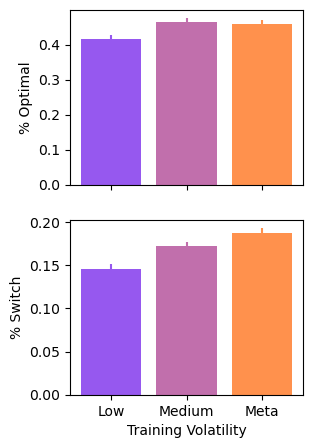

In [21]:
fig, axs = plt.subplots(2,1, figsize=(3,5))

axs[0].bar(x, y[0], color=colors)
axs[0].set_ylabel('% Optimal')
axs[0].set_xlabel('')
axs[0].errorbar(x, y[0], yerr=c[0], fmt="none", ecolor = colors)
plt.setp(axs[0].get_xticklabels(), visible=False)

axs[1].bar(x, y[1], color=colors)
axs[1].set_ylabel('% Switch')
axs[1].set_xlabel('Training Volatility')
axs[1].errorbar(x, y[1], yerr=c[1], fmt="none", ecolor = colors)

#plt.show()
plt.savefig('../plots/accuracy_switch_barplot.svg', dpi = 300, bbox_inches='tight')

In [22]:
# save files for jasp

acc = []
switch = []
grp = []

for i,tsd in enumerate(train_sds):
    acc.append(df_list[i]['accuracy'])
    switch.append(df_list[i]['is_switch'])
    grp.append([tsd]*len(df_list[i]['accuracy']))

In [23]:
df = pd.DataFrame({'acc':np.array(acc).flatten(), 'switch':np.array(switch).flatten(), 'grp':np.array(grp).flatten()})
df.to_csv('../data/intermediate_data/accuracy_switch_barplot_data.csv')

# CUT

In [ ]:
# create color gradient
my_colors = ['#9658EF', '#FF914D'] # define 2 colors of the ends

lcm = LinearSegmentedColormap.from_list(
        "Custom", my_colors, N=15)

my_norm = cols.Normalize(0, 0.32)
my_map = cm.ScalarMappable(norm=my_norm, cmap=lcm)

my_map.to_rgba(x)

In [168]:
y    = my_ys[ax][i]
cols = np.linspace(0,1,len(x))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=lcm)
lc.set_array(cols)
lc.set_linewidth(2)
line = axs[ax].add_collection(lc)

[array([0.75666667, 0.69666667, 0.68666667, 0.775     , 0.74666667,
        0.75      , 0.705     , 0.72333333, 0.75166667, 0.72166667,
        0.71333333, 0.72833333, 0.75166667, 0.715     , 0.73833333,
        0.71166667, 0.75333333, 0.73      , 0.755     , 0.74666667,
        0.69333333, 0.695     , 0.68166667, 0.75      , 0.68333333,
        0.755     , 0.72666667, 0.69333333, 0.775     , 0.70166667]),
 array([0.08166667, 0.08333333, 0.085     , 0.07666667, 0.08166667,
        0.06333333, 0.10166667, 0.10833333, 0.08166667, 0.08833333,
        0.12      , 0.08666667, 0.07666667, 0.09333333, 0.06833333,
        0.07333333, 0.09166667, 0.07166667, 0.11666667, 0.11      ,
        0.06833333, 0.15666667, 0.11      , 0.09833333, 0.10166667,
        0.08666667, 0.10166667, 0.09166667, 0.07166667, 0.085     ])]

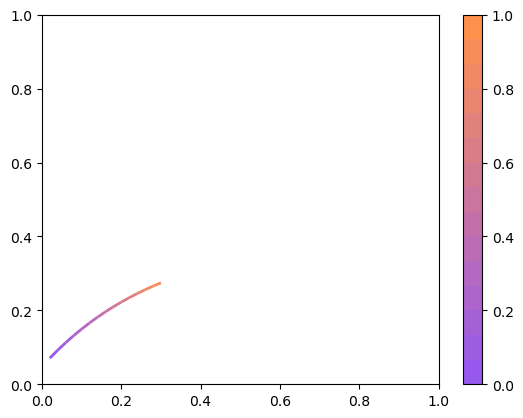

In [161]:
x    = x#np.linspace(0,1, 100)
y    = my_ys[ax][i]
cols = np.linspace(0,1,len(x))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots()
lc = LineCollection(segments, cmap=lcm)
lc.set_array(cols)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line,ax=ax)

In [163]:
cols

array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])

In [164]:
my_map.to_rgba(x)

array([[0.58823529, 0.34509804, 0.9372549 , 1.        ],
       [0.61764706, 0.36106443, 0.89187675, 1.        ],
       [0.64705882, 0.37703081, 0.8464986 , 1.        ],
       [0.67647059, 0.3929972 , 0.80112045, 1.        ],
       [0.70588235, 0.40896359, 0.7557423 , 1.        ],
       [0.73529412, 0.42492997, 0.71036415, 1.        ],
       [0.76470588, 0.44089636, 0.66498599, 1.        ],
       [0.79411765, 0.45686275, 0.61960784, 1.        ],
       [0.82352941, 0.47282913, 0.57422969, 1.        ],
       [0.85294118, 0.48879552, 0.52885154, 1.        ],
       [0.88235294, 0.5047619 , 0.48347339, 1.        ],
       [0.91176471, 0.52072829, 0.43809524, 1.        ],
       [0.94117647, 0.53669468, 0.39271709, 1.        ],
       [0.97058824, 0.55266106, 0.34733894, 1.        ],
       [1.        , 0.56862745, 0.30196078, 1.        ]])